__<span style="background-color:#ffffe0">第5章　時系列データを活用したビジネス事例</span>__

# 5.6　既存顧客のLTV予測による顧客選別（ECサイト）

## ステップ1：準備

### 必要なモジュールの読み込み

In [1]:
#
# 必要なモジュールの読み込み
#

import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_probability_alive_matrix

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフスタイル
plt.rcParams['figure.figsize'] = [12, 9] #グラフサイズ
plt.rcParams['font.size'] = 14 #フォントサイズ

### データセットの読み込み

In [2]:
#
# 必要なデータセットの読み込み
#

dataset = 'chap5_8.csv'
df=pd.read_csv(dataset)

print(df) #確認

        Invoice_No Customer_ID  Item_Code  Quantity  Unit_Price Invoice_Date
0        201800003    cid90527  item80698         3         714     2018/1/1
1        201900003    cid90527  item80698         3         714     2019/1/1
2        201800003    cid90527  item90699         3         714     2018/1/1
3        201900003    cid90527  item90699         3         714     2019/1/1
4        201800003    cid90527  item70710         4         954     2018/1/1
...            ...         ...        ...       ...         ...          ...
463585   201917753    cid80067  item63059        12         102   2019/12/31
463586   201917753    cid80067  item32487        36         252   2019/12/31
463587   201917753    cid80067  item42635        24          78   2019/12/31
463588   201917753    cid80067  item33371        12         234   2019/12/31
463589   201917753    cid80067  item83372        24         234   2019/12/31

[463590 rows x 6 columns]


### RFMデータセットの生成

In [3]:
#
# トランザクションデータ（顧客×日付ごと購買金額）の作成
#

# 合計金額を計算
df['Amount'] = df['Quantity'] * df['Unit_Price']

# 顧客ID・日時・金額のトランザクションデータを生成
transaction_data = df.groupby(
    ['Customer_ID', 'Invoice_Date']
    )['Amount'].sum().reset_index()

print(transaction_data) #確認

      Customer_ID Invoice_Date  Amount
0        cid10009     2018/6/9   55128
1        cid10009     2019/6/9   55128
2        cid10011    2018/12/7  745342
3        cid10011    2019/12/7  745342
4        cid10012    2018/8/12   58188
...           ...          ...     ...
20778    cid94265     2019/6/5   56014
20779    cid94274   2018/10/14  521640
20780    cid94274   2019/10/14  521640
20781    cid94289   2018/12/10   21114
20782    cid94289   2019/12/10   21114

[20783 rows x 3 columns]


In [4]:
#
# 全データ期間のRFMデータセットの生成
#

# RFMデータセット生成
rfm = summary_data_from_transaction_data(
    transaction_data,
    'Customer_ID',
    'Invoice_Date',
    observation_period_end='2019-12-31',
    monetary_value_col = 'Amount')

# frequencyが1以上のデータに絞る
rfm = rfm.loc[rfm['frequency'] > 0]

# データセットの確認
print(rfm)

             frequency  recency      T  monetary_value
Customer_ID                                           
cid10009           1.0    365.0  570.0    55128.000000
cid10011           1.0    365.0  389.0   745342.000000
cid10056          15.0    683.0  713.0    50167.733333
cid10082           1.0    365.0  400.0    53958.000000
cid10094           2.0    365.0  374.0    71400.000000
...                ...      ...    ...             ...
cid94229           1.0    365.0  521.0    29268.000000
cid94258          12.0    658.0  658.0    46155.000000
cid94265           8.0    519.0  728.0    39446.500000
cid94274           1.0    365.0  443.0   521640.000000
cid94289           1.0    365.0  386.0    21114.000000

[2606 rows x 4 columns]


In [5]:
# 基礎統計料

print(rfm.describe())

         frequency      recency            T  monetary_value
count  2606.000000  2606.000000  2606.000000    2.606000e+03
mean      6.871067   478.749041   582.400614    5.155087e+04
std      13.135740   140.619425   123.292234    1.906687e+05
min       1.000000    21.000000    73.000000    4.140000e+02
25%       1.000000   365.000000   459.500000    2.111629e+04
50%       2.000000   365.000000   617.000000    3.618336e+04
75%       9.000000   625.000000   693.000000    5.394807e+04
max     243.000000   729.000000   729.000000    9.276875e+06


In [6]:
#
# 期間分割されたRFMデータセットの生成
#（学習データ期間：2018年、テストデータ期間：2019年）
#

# 分割の実施
rfm_train_test = calibration_and_holdout_data(
    transaction_data,
    'Customer_ID',
    'Invoice_Date',
    calibration_period_end='2018-12-31',
    observation_period_end='2019-12-31',
    monetary_value_col = 'Amount')

# 学習データ期間のfrequency（frequency_cal）が1以上のデータに絞る
rfm_train_test = rfm_train_test.loc[
    rfm_train_test.frequency_cal > 0, :]

# データセットの確認
print(rfm_train_test)

             frequency_cal  recency_cal  T_cal  monetary_value_cal  \
Customer_ID                                                          
cid10056               7.0        318.0  348.0        51253.714286   
cid10099              18.0        354.0  355.0       101542.166667   
cid10110               5.0        304.0  327.0        81356.800000   
cid10137               4.0        194.0  264.0        49427.000000   
cid10150               1.0         16.0   50.0       499328.000000   
...                    ...          ...    ...                 ...   
cid94133               4.0        278.0  355.0        26884.500000   
cid94182               1.0        114.0  124.0        24916.000000   
cid94212               2.0        180.0  229.0        27418.000000   
cid94258               6.0        293.0  293.0        46922.000000   
cid94265               4.0        154.0  363.0        33716.500000   

             frequency_holdout  monetary_value_holdout  duration_holdout  
Customer_ID   

## ステップ2：予測モデルの作り方の検討

### 購買回数の期待値を予測するためのBG/NBDモデルの学習と評価

In [7]:
#
# BG/NBDモデルの学習（学習データ期間）
#

# インスタンス生成
bgf = BetaGeoFitter()

# 学習
bgf.fit(
    rfm_train_test['frequency_cal'],
    rfm_train_test['recency_cal'],
    rfm_train_test['T_cal'])

# パラメータ
print(bgf.summary)

            coef  se(coef)  lower 95% bound  upper 95% bound
r       1.932577  0.099826         1.736918         2.128236
alpha  92.492518  5.174824        82.349863       102.635173
a       0.002889  0.003165        -0.003315         0.009093
b       0.054415  0.060400        -0.063969         0.172800


In [8]:
#
# テストデータ期間の予測
#

# 予測期間（日単位）
duration_holdout = 365

# 予測
predicted_bgf = bgf.predict(
    duration_holdout,
    rfm_train_test['frequency_cal'],
    rfm_train_test['recency_cal'],
    rfm_train_test['T_cal'])

In [9]:
#
# 予測精度（テストデータ期間）
#

# 実測値と予測値の代入
actual = rfm_train_test['frequency_holdout']
pred = predicted_bgf

# 精度指標（テストデータ）
print('R2:\n', r2_score(actual, pred))

R2:
 0.914224168902585


### 購買金額／回を予測するためのGGモデルの学習と評価

In [10]:
#
# GGモデルの学習（学習期間）
#

# インスタンス生成
ggf = GammaGammaFitter()

# 学習
ggf.fit(
    rfm_train_test['frequency_cal'],
    rfm_train_test['monetary_value_cal'])

# パラメータ
print(ggf.summary)

           coef     se(coef)  lower 95% bound  upper 95% bound
p      1.822489     0.151723         1.525112         2.119866
q      3.197497     0.177838         2.848935         3.546058
v  63814.925300  8231.721761     47680.750649     79949.099951


In [11]:
#
# テストデータ期間の予測
#

# 予測
predicted_ggf = ggf.conditional_expected_average_profit(
    rfm_train_test['frequency_cal'],
    rfm_train_test['monetary_value_cal'])

In [12]:
#
# 予測精度（テストデータ期間）
#

# 実測値と予測値の代入
actual = rfm_train_test['monetary_value_holdout']
pred = predicted_ggf

# 精度指標（テストデータ）
print('R2:\n', r2_score(actual, pred))

R2:
 0.8826469830368177


### テストデータ期間のLTV（購買金額）予測の実施

In [13]:
#
# LTV（購買金額）の予測
#

# 予測期間（月単位）
forecast_period = 12

# 予測の実施
ltv = ggf.customer_lifetime_value(
    bgf,
    rfm_train_test['frequency_cal'],
    rfm_train_test['recency_cal'],
    rfm_train_test['T_cal'],
    rfm_train_test['monetary_value_cal'],
    time=forecast_period,
    freq='D',
    discount_rate=0.01)

print(ltv) #確認

Customer_ID
cid10056    3.518724e+05
cid10099    1.479488e+06
cid10110    4.221163e+05
cid10137    2.808376e+05
cid10150    1.578562e+06
                ...     
cid94133    1.467094e+05
cid94182    1.726887e+05
cid94212    1.517106e+05
cid94258    3.323381e+05
cid94265    1.617617e+05
Name: clv, Length: 1267, dtype: float64


In [14]:
#
# 予測精度（テストデータ期間）
#

# データセットに予測結果を追加
rfm_train_test['ltv'] = ltv

# 実測値と予測値の代入
actual = rfm_train_test['frequency_holdout']*\
         rfm_train_test['monetary_value_holdout']
pred = rfm_train_test['ltv'] 

# 予測精度
print('R2:\n', r2_score(actual, pred))

R2:
 0.9151575365778064


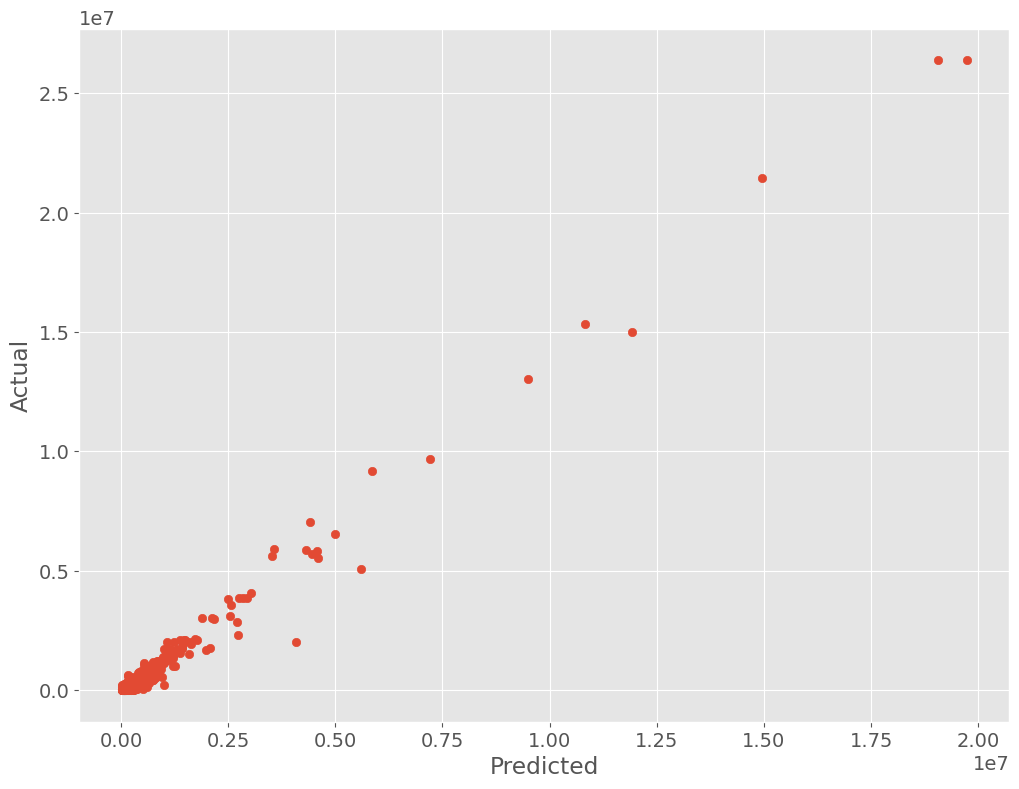

In [15]:
#
# グラフ化
#

# 散布図
plt.scatter(pred, actual)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## ステップ3：LTV（購買金額）予測とリスト生成

### LTV（購買金額）予測モデルの構築（全データ期間のRFMデータセット）

In [16]:
#
# LTV予測モデルの構築（全データ期間のRFMデータセット）
#

# BG/NBDモデルの学習
bgf = BetaGeoFitter().fit(
    rfm['frequency'],
    rfm['recency'],
    rfm['T'])

# GGモデルの学習
ggf = GammaGammaFitter().fit(
    rfm['frequency'],
    rfm['monetary_value'])

### 生存確率と離反確率

In [17]:
#
# 生存確率と離反確率
#

# 生存確率
alive = bgf.conditional_probability_alive(
    rfm['frequency'],
    rfm['recency'],
    rfm['T'])

# 離反確率の確認
print(1-alive)

[2.05502282e-12 1.11666232e-12 1.85984561e-12 ... 1.42534873e-11
 1.36868294e-12 1.10333964e-12]


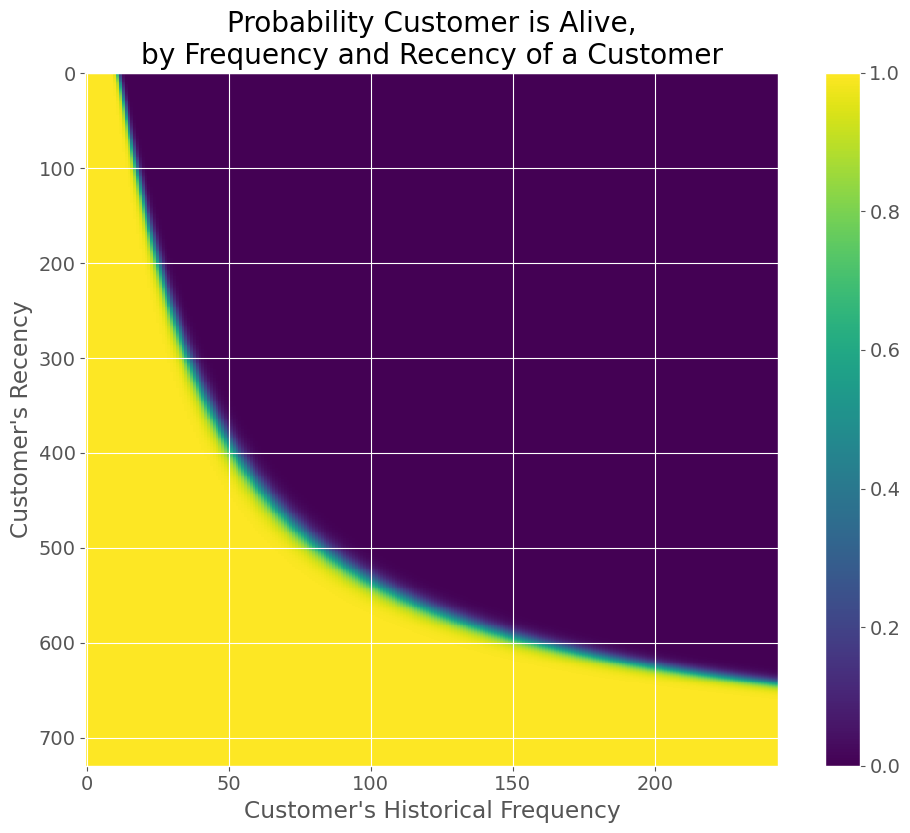

In [18]:
#
# グラフ化
#

plot_probability_alive_matrix(bgf)
plt.show()

### LTV（購買金額）予測とリスト生成

In [19]:
#
# 次年度のLTV（購買金額）の予測
#

# 予測期間（月単位）
forecast_period = 12

# 予測の実施
ltv = ggf.customer_lifetime_value(
    bgf, 
    rfm['frequency'],
    rfm['recency'],
    rfm['T'],
    rfm['monetary_value'],
    time=forecast_period,
    freq='D',
    discount_rate=0.01)

# データセットにLTV追加
rfm['ltv'] = ltv

print(rfm) #確認

             frequency  recency      T  monetary_value            ltv
Customer_ID                                                          
cid10009           1.0    365.0  570.0    55128.000000   51053.681848
cid10011           1.0    365.0  389.0   745342.000000  591592.103154
cid10056          15.0    683.0  713.0    50167.733333  337534.145775
cid10082           1.0    365.0  400.0    53958.000000   68152.775886
cid10094           2.0    365.0  374.0    71400.000000  138612.489212
...                ...      ...    ...             ...            ...
cid94229           1.0    365.0  521.0    29268.000000   39939.581825
cid94258          12.0    658.0  658.0    46155.000000  271912.099747
cid94265           8.0    519.0  728.0    39446.500000  149014.283433
cid94274           1.0    365.0  443.0   521640.000000  379359.690640
cid94289           1.0    365.0  386.0    21114.000000   45237.434272

[2606 rows x 5 columns]


In [20]:
#
# LTV降順リスト
#

print(rfm[['ltv']].sort_values('ltv',ascending=False))

                      ltv
Customer_ID              
cid61672     2.194284e+07
cid24162     2.141537e+07
cid93693     1.713961e+07
cid40055     1.296105e+07
cid91861     1.241815e+07
...                   ...
cid80396     1.889731e+04
cid81826     1.886040e+04
cid43185     1.882693e+04
cid41624     1.875495e+04
cid32533     1.767939e+04

[2606 rows x 1 columns]


In [21]:
#
# 多期間LTV（購買金額）予測とリスト生成
#

# LTV12予測（1年間）
ltv = ggf.customer_lifetime_value(
    bgf, 
    rfm['frequency'],
    rfm['recency'],
    rfm['T'],
    rfm['monetary_value'],
    time=12,
    freq='D',
    discount_rate=0.01)
rfm['ltv'] = ltv

# LTV36予測（3年間）
ltv = ggf.customer_lifetime_value(
    bgf, 
    rfm['frequency'],
    rfm['recency'],
    rfm['T'],
    rfm['monetary_value'],
    time=36,
    freq='D',
    discount_rate=0.01 )
rfm['ltv36'] = ltv

# LTV120予測（10年間）
ltv = ggf.customer_lifetime_value(
    bgf, 
    rfm['frequency'],
    rfm['recency'],
    rfm['T'],
    rfm['monetary_value'],
    time=120,
    freq='D',
    discount_rate=0.01)
rfm['ltv120'] = ltv

# LTV1200予測（100年間）
ltv = ggf.customer_lifetime_value(
    bgf, 
    rfm['frequency'],
    rfm['recency'],
    rfm['T'],
    rfm['monetary_value'],
    time=1200,
    freq='D',
    discount_rate=0.01)
rfm['ltv1200'] = ltv

# LTV降順リスト
print(
    rfm[['ltv','ltv36','ltv120','ltv1200']
       ].sort_values('ltv', ascending=False))

                      ltv         ltv36        ltv120       ltv1200
Customer_ID                                                        
cid61672     2.194284e+07  5.869744e+07  1.358878e+08  1.949582e+08
cid24162     2.141537e+07  5.728644e+07  1.326212e+08  1.902717e+08
cid93693     1.713961e+07  4.584872e+07  1.061423e+08  1.522824e+08
cid40055     1.296105e+07  3.467100e+07  8.026526e+07  1.151566e+08
cid91861     1.241815e+07  3.321874e+07  7.690320e+07  1.103330e+08
...                   ...           ...           ...           ...
cid80396     1.889731e+04  5.055058e+04  1.170274e+05  1.678992e+05
cid81826     1.886040e+04  5.045186e+04  1.167988e+05  1.675713e+05
cid43185     1.882693e+04  5.036233e+04  1.165915e+05  1.672739e+05
cid41624     1.875495e+04  5.016979e+04  1.161458e+05  1.666344e+05
cid32533     1.767939e+04  4.729265e+04  1.094851e+05  1.570783e+05

[2606 rows x 4 columns]


In [22]:
# 基礎統計料

print(rfm.describe())

         frequency      recency            T  monetary_value           ltv  \
count  2606.000000  2606.000000  2606.000000    2.606000e+03  2.606000e+03   
mean      6.871067   478.749041   582.400614    5.155087e+04  2.304558e+05   
std      13.135740   140.619425   123.292234    1.906687e+05  9.142430e+05   
min       1.000000    21.000000    73.000000    4.140000e+02  1.767939e+04   
25%       1.000000   365.000000   459.500000    2.111629e+04  4.087440e+04   
50%       2.000000   365.000000   617.000000    3.618336e+04  6.629646e+04   
75%       9.000000   625.000000   693.000000    5.394807e+04  1.785293e+05   
max     243.000000   729.000000   729.000000    9.276875e+06  2.194284e+07   

              ltv36        ltv120       ltv1200  
count  2.606000e+03  2.606000e+03  2.606000e+03  
mean   6.164728e+05  1.427168e+06  2.047558e+06  
std    2.445614e+06  5.661730e+06  8.122885e+06  
min    4.729265e+04  1.094851e+05  1.570783e+05  
25%    1.093396e+05  2.531273e+05  3.631617e+05